# Train a Model to Predict Formation Energy using the MDF
This notebook demonstrates how to create an model to predict the formation energy of crystalline materials using data from the MDF. Specifically, we will use data from the OQMD and train a model using the technique describe in a recent paper by [Ward *et al.*](https://www.nature.com/articles/npjcompumats201628)

In [1]:
%matplotlib inline
from mdf_forge.forge import Forge
from pymatgen import Composition
from pymatgen.core.periodic_table import Element
from matminer.featurizers import composition as cf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn import metrics
from matplotlib import pyplot as plt
import numpy as np
import itertools
import pandas as pd

Settings to change

In [2]:
quick_demo = True # Whether to run an faster version of this demo

## Get OQMD Training Set
Ward _et al._ trained their machine learning models on the formation enthalpies of crystalline compounds form the [OQMD](oqmd.org). Here, we extract the data using the copy of the OQMD available through the MDF

### Download the Data
We first create a `Forge` instance, which simplifies performing search queries against the MDF.

In [3]:
forge = Forge()

Then, we get all the converged results from the OQMD

In [4]:
query_string = 'mdf.source_name:oqmd AND (oqmd.configuration:static OR oqmd.configuration:standard) AND oqmd.converged:True'
if quick_demo:
    query_string += " AND mdf.scroll_id:<10000"
result_records = forge.aggregate(query_string)
print('Found %d compounds'%len(result_records))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6847/6847 [00:13<00:00, 499.19it/s]


Found 6847 compounds


Each of these results contain the key metadata of these OQMD compositions.

In [5]:
result_records[0]

{'mdf': {'collection': 'OQMD',
  'composition': 'B2Ir3Y1',
  'elements': ['Ir', 'Y', 'B'],
  'ingest_date': '2017-08-04T14:19:15.469713Z',
  'links': {'landing_page': 'http://oqmd.org/analysis/calculation/19616',
   'metadata': {'globus_endpoint': '82f1b5c6-6e9b-11e5-ba47-22000b92c6ec',
    'http_host': 'https://data.materialsdatafacility.org',
    'path': '/collections/oqmd/data/home/oqmd/libraries/icsd/614578/static/metadata.json'},
   'outcar': {'globus_endpoint': '82f1b5c6-6e9b-11e5-ba47-22000b92c6ec',
    'http_host': 'https://data.materialsdatafacility.org',
    'path': '/collections/oqmd/data/home/oqmd/libraries/icsd/614578/static/OUTCAR'},
   'parent_id': '5984824ba5ea60170af49754'},
  'mdf_id': '59848263a5ea60172af4aadd',
  'metadata_version': '0.3.2',
  'resource_type': 'record',
  'scroll_id': 5001,
  'source_name': 'oqmd',
  'tags': ['metadata', 'outcar'],
  'title': 'OQMD - B2Ir3Y1'},
 'oqmd': {'band_gap': {'units': 'eV', 'value': 0.0},
  'configuration': 'static',
  'conv

### Compile the Training Set
First transform the data into a Pandas DataFrame, then get only the lowest-energy compound at each composition

In [6]:
data = pd.DataFrame([x['mdf']['links']['landing_page'] for x in result_records], columns=['oqmd_url'])

Get the composition and $\Delta H_f$

In [7]:
def get_data(entry):
    """Get the composition, structure, band gap, and stability of an entry given its search result
    
    :param entry: dict, metadata for an entry as returned by Globus search
    :return: Several items
        - str, composition of the material
        - float, band-gap energy of material
        - float, Energy per atom (eV/atom)"""
    
    
    # Get the metadata as a dict
    oqmd_data = entry['oqmd']
    
    # Return results
    return entry['mdf']['composition'], \
        oqmd_data.get('delta_e', {}).get('value'), \
        oqmd_data['total_energy'].get('value', np.nan)

In [8]:
data['composition'], data['delta_e'], data['energy'] = list(zip(*[get_data(x) for x in result_records]))

Convert compositions to `pymatgen` objects

In [9]:
data['composition_pmg'] = data['composition'].apply(lambda x: Composition(x))

Remove compounds w/o a `delta_e` measurement.

In [10]:
original_count = len(data)
data = data[~ np.logical_or(data['delta_e'].isnull(), data['energy'].isnull())]
print('Removed %d/%d entires'%(original_count - len(data), original_count))

Removed 1/6847 entires


Get only the groundstate and each composition

In [11]:
%%time
original_count = len(data)
data['composition_str'] = data['composition_pmg'].apply(lambda x: x.reduced_formula)
data.sort_values('energy', ascending=True, inplace=True)
data.drop_duplicates('composition_str', keep='first', inplace=True)
print('Removed %d/%d entires'%(original_count - len(data), original_count))

c:\users\ward6\documents\code\python\pymatgen\pymatgen\core\periodic_table.py:398: UserWarning: No electronegativity for He. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
c:\users\ward6\documents\code\python\pymatgen\pymatgen\core\periodic_table.py:398: UserWarning: No electronegativity for Ne. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


Removed 1014/6846 entires
Wall time: 482 ms


## Build an ML model
In this part of the notebook, we build a ML model using [scikit-learn](http://scikit-learn.org/stable/) and evaluate its performance using cross-validation.

### Part 1: Compute Representation
The first step in building a ML model is to convert the raw materials data (here: the composition) into the required input for an ML model: a finite list of quantitative attributes. In this example, we use the "general-purpose" attributes of [Ward *et al* 2016](https://www.nature.com/articles/npjcompumats201628).

In [12]:
feature_calculators = [cf.Stoichiometry(), cf.ElementProperty(method="magpie"), \
                      cf.ValenceOrbital(props=['frac']), cf.IonProperty()]

Get the feature names

In [13]:
feature_labels = list(itertools.chain.from_iterable([x.feature_labels() for x in feature_calculators]))

Compute the features

In [14]:
%%time
for fc in feature_calculators:
    data = fc.featurize_dataframe(data, col_id='composition_pmg')

c:\users\ward6\documents\code\python\pymatgen\pymatgen\core\periodic_table.py:398: UserWarning: No electronegativity for Ne. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
c:\users\ward6\documents\code\python\pymatgen\pymatgen\core\periodic_table.py:398: UserWarning: No electronegativity for He. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


Wall time: 22.9 s


In [15]:
print('Generated %d features'%len(feature_labels))
print('Training set size:', 'x'.join([str(x) for x in data[feature_labels].shape]))

Generated 145 features
Training set size: 5832x145


Remove entries with `NaN` or `infinite` features

In [16]:
original_count = len(data)
data = data[~ data[feature_labels].isnull().any(axis=1)]
print('Removed %d/%d entires'%(original_count - len(data), original_count))

Removed 2/5832 entires


### Part 2: Tuning Model Hyper-parameters
For brevity, we will only consider one ML algorithm in this example: [random forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor). The "random forest" algorithm works by training many different decision tree models, where each is trained on a different subset of the dataset . Here, we tune one of the major parameters of the algoritm: the number features considered at each split in each decision tree

In [17]:
model = GridSearchCV(RandomForestRegressor(n_estimators=20),
                     param_grid=dict(max_features=range(8,15)),
                     scoring='neg_mean_squared_error',
                     n_jobs=-1,
                    cv=10)

In [18]:
model.fit(data[feature_labels], data['delta_e'])

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': range(8, 15)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

Plot the tuning results. This shows the CV score as a function of the parameter we tuned "max features"

In [19]:
model.best_score_

-0.081157854369870455

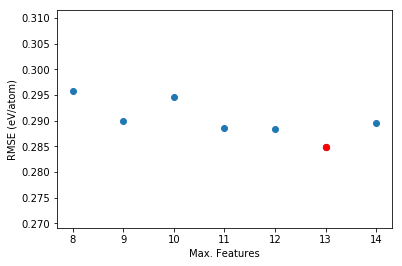

In [20]:
fig, ax = plt.subplots()

# Plot the score as a function of alpha
ax.scatter(model.cv_results_['param_max_features'].data,
          np.sqrt(-1 * model.cv_results_['mean_test_score']))
ax.scatter([model.best_params_['max_features']], np.sqrt([-1*model.best_score_]), marker='o', color='r', s=40)
ax.set_xlabel('Max. Features')
ax.set_ylabel('RMSE (eV/atom)')

Save our best model

In [21]:
model = model.best_estimator_

### Part 3: Cross-validation Test
Quantify the performance of this model using 10-fold cross-validation

In [22]:
cv_prediction = cross_val_predict(model, data[feature_labels], data['delta_e'], cv=10, n_jobs=-1)

Compute aggregate statistics

In [23]:
for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
    score = getattr(metrics,scorer)(data['delta_e'], cv_prediction)
    print(scorer, score)

r2_score 0.876043829149
mean_absolute_error 0.176689685706
mean_squared_error 0.0828124639831


Plot the individual predictions

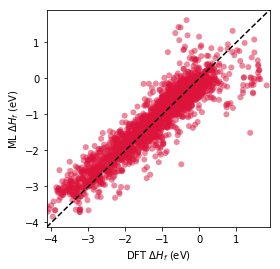

In [24]:
fig, ax = plt.subplots()

ax.scatter(data['delta_e'], cv_prediction, color='crimson', alpha=0.5, edgecolor='none')

ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('DFT $\Delta H_f$ (eV)')
ax.set_ylabel('ML $\Delta H_f$ (eV)')

fig.set_size_inches(4, 4)